#Imports and functions

In [ ]:
pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for fbprophet
  Running setup.py clean for fbprophet
Failed to build fbprophet
  error: subprocess-exited-with-error
  
  × Running setup.py install for fbprophet did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Running setup.py install for fbprophet ... error
error: legacy-install-failure

× Encountered error while trying to install package.
╰─> fbprophet

note: This is an issue with the package mentioned above, not pip.
hint: See

In [ ]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product
from tqdm import tqdm_notebook

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from prophet import Prophet

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

from datetime import datetime

from pmdarima import auto_arima


# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter(action='ignore')

In [ ]:
from zipfile import ZipFile
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """

    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

In [ ]:
def plotModelResults(model, X_train, X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies

    """

    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)


    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train,
                                    cv=tscv,
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()

        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)

        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)

        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")

    error = mean_absolute_error(prediction, y_test)
    plt.title(f"Mean absolute error {error}")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    plt.show()

    errors = y_test - prediction

    plt.subplots(1, 2, figsize=(24, 8))

    plt.subplot(1, 2, 1)
    sns.lineplot(prediction,errors, color='r').set(title='Residual')
    plt.grid(linestyle=':')
    plt.title("Residuals")

    plt.subplot(1, 2, 2)
    sns.distplot(errors, bins=100, vertical=True, label="distribution of residuals")
    plt.title("Distribution of residuals")
    plt.grid(linestyle=':')

    plt.show()


def plotCoefficients(model, X_train):
    """
        Plots sorted coefficient values of the model
    """

    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [ ]:
def decompose(data, period=None, title=None):
  decomposition = seasonal_decompose(data, period=period, extrapolate_trend='freq')

  trend = decomposition.trend
  seasonal = decomposition.seasonal

  plot = decomposition.plot()
  plot.suptitle(title, fontsize=20)
  plot.set_size_inches(24, 10)

  return trend, seasonal

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [ ]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(data[-8904:].cnt, order=(param[0], d, param[1]),
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table


def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values

        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future

    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = 0#np.NaN

    # forecasting on n_steps forward
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title(f"Mean Absolute Percentage Error: {error}")
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

In [ ]:
def train_test_arima(p, d, q, steps, train_data, test_data, transformation=None, back_transformation=None):
  train_data_transformed = transformation(train_data) if transformation is not None else train_data

  arima_model = ARIMA(train_data_transformed, order=(p, d, q)).fit()

  print(f"ARIMA model ({p}, {d}, {q}):")
  print(arima_model.summary())

  prediction_arima_train = arima_model.predict(train_data_transformed.index[0], train_data_transformed.index[-1])
  prediction_arima_test = arima_model.forecast(steps)

  if back_transformation is not None:
    prediction_arima_train = back_transformation(prediction_arima_train)
    prediction_arima_test = back_transformation(prediction_arima_test)

  prediction_arima_test = pd.DataFrame(prediction_arima_test).set_index(test_data.index)

  mae_arima = mean_absolute_error(y_true=test_data, y_pred=prediction_arima_test)
  print('ARIMA MAE: ', mae_arima)

  fig, ax = plt.subplots(figsize=(24,6))
  ax = train_data.plot(ax=ax)
  test_data.plot(ax=ax)
  prediction_arima_train.plot(ax=ax, alpha=0.5)
  prediction_arima_test.plot(ax=ax, alpha=0.5)
  plt.show()

  return prediction_arima_test

In [ ]:
def perform_auto_arima(data):
  auto_arima_model = auto_arima(
    data,
    start_p=1,
    start_q=1,
    test='adf', # use adftest to find optimal 'd'
    max_p=16, max_q=16, # maximum p and q
    m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
    d=None,# let model determine 'd'
    seasonal=False, # No Seasonality for standard ARIMA
    trace=False, #logs
    error_action='warn', #shows errors ('ignore' silences these)
    suppress_warnings=True,
    stepwise=True)

  print(auto_arima_model.summary())

  auto_arima_model.plot_diagnostics(figsize=(15,12))
  plt.show()

#EDA

Link to the previous HW: https://colab.research.google.com/drive/1_3pz5137OGyqimj08bIubRASTXbC4cfT?usp=sharing

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/hour.csv')
df.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

Let's create a dataframe that represents the exact time and number of bikes rented.

In [ ]:
data = df[['dteday', 'hr', 'cnt']]
data['date_time'] = df['dteday'].astype('str') + "-" + df['hr'].astype('str')
data['date_time'] = pd.to_datetime(data['date_time'], format="%Y-%m-%d-%H")
data = data.set_index(pd.DatetimeIndex(data['date_time']))
data = data.drop(columns=['dteday', 'hr', 'date_time'])
data

cnt
date_time               
2011-01-01 00:00:00   16
2011-01-01 01:00:00   40
2011-01-01 02:00:00   32
2011-01-01 03:00:00   13
2011-01-01 04:00:00    1
...                  ...
2012-12-31 19:00:00  119
2012-12-31 20:00:00   89
2012-12-31 21:00:00   90
2012-12-31 22:00:00   61
2012-12-31 23:00:00   49

[17379 rows x 1 columns]

##Decomposition and visualization

<AxesSubplot:xlabel='date_time'>

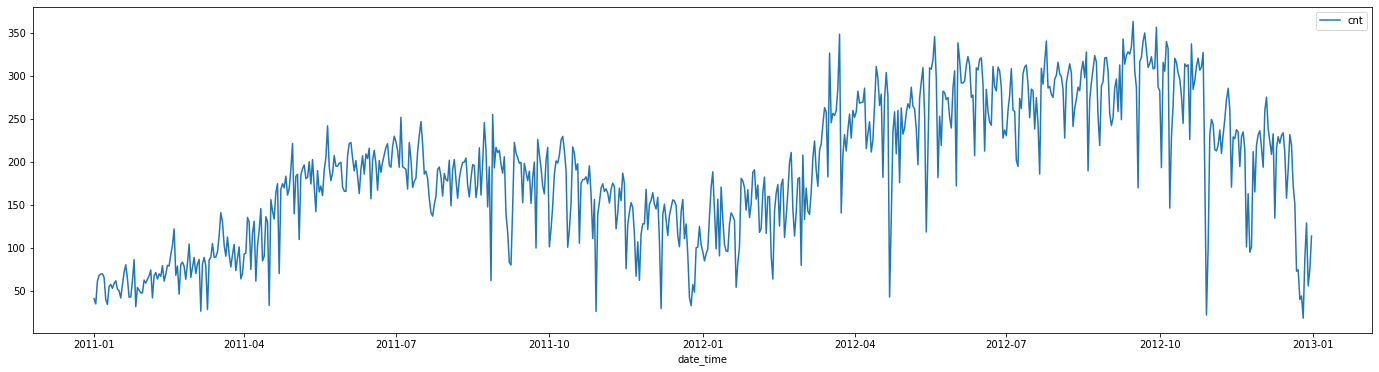

In [ ]:
plt.figure(figsize=(24,6))
sns.lineplot(data=data.resample('D').mean())

Now we can use `seasonal_decompose` to see the trend and seasonality. Let's start with hourly data and set the period to 24.

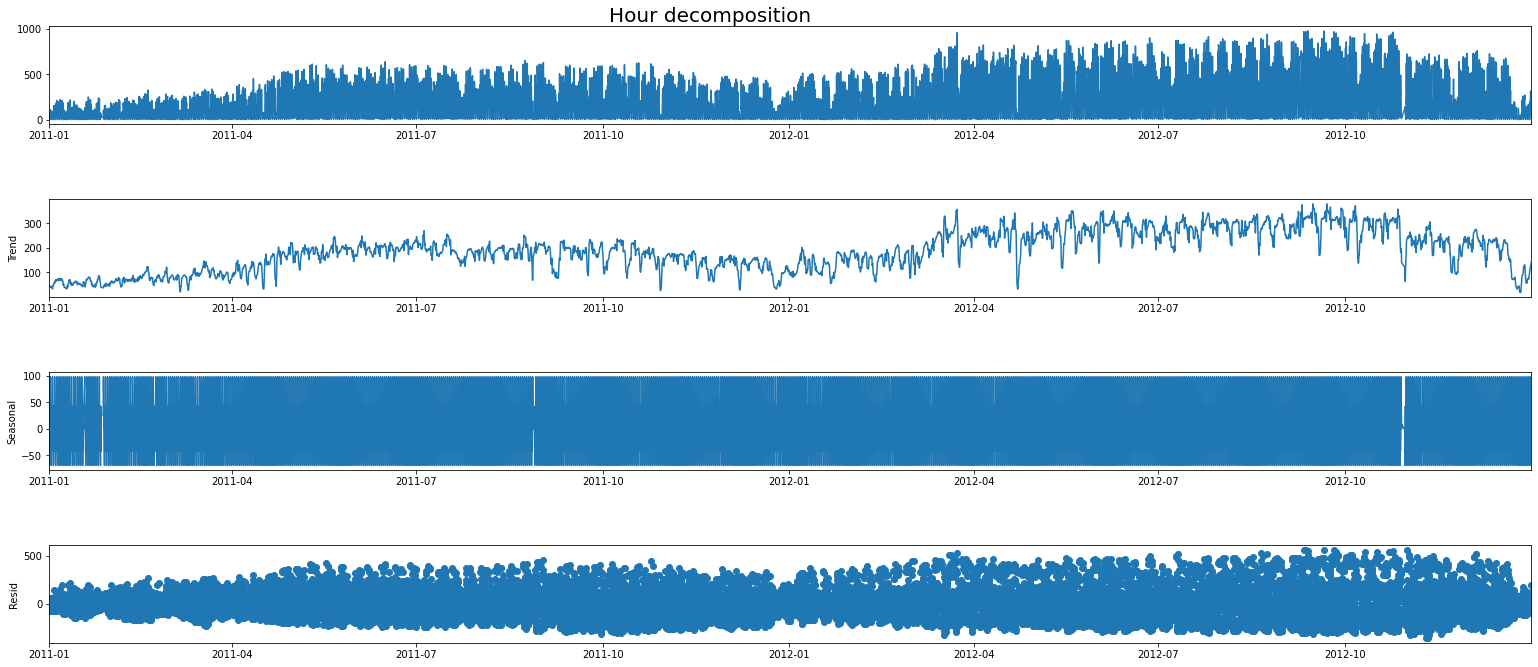

In [ ]:
hour_trend, hour_seasonal = decompose(data, period=24, title='Hour decomposition')

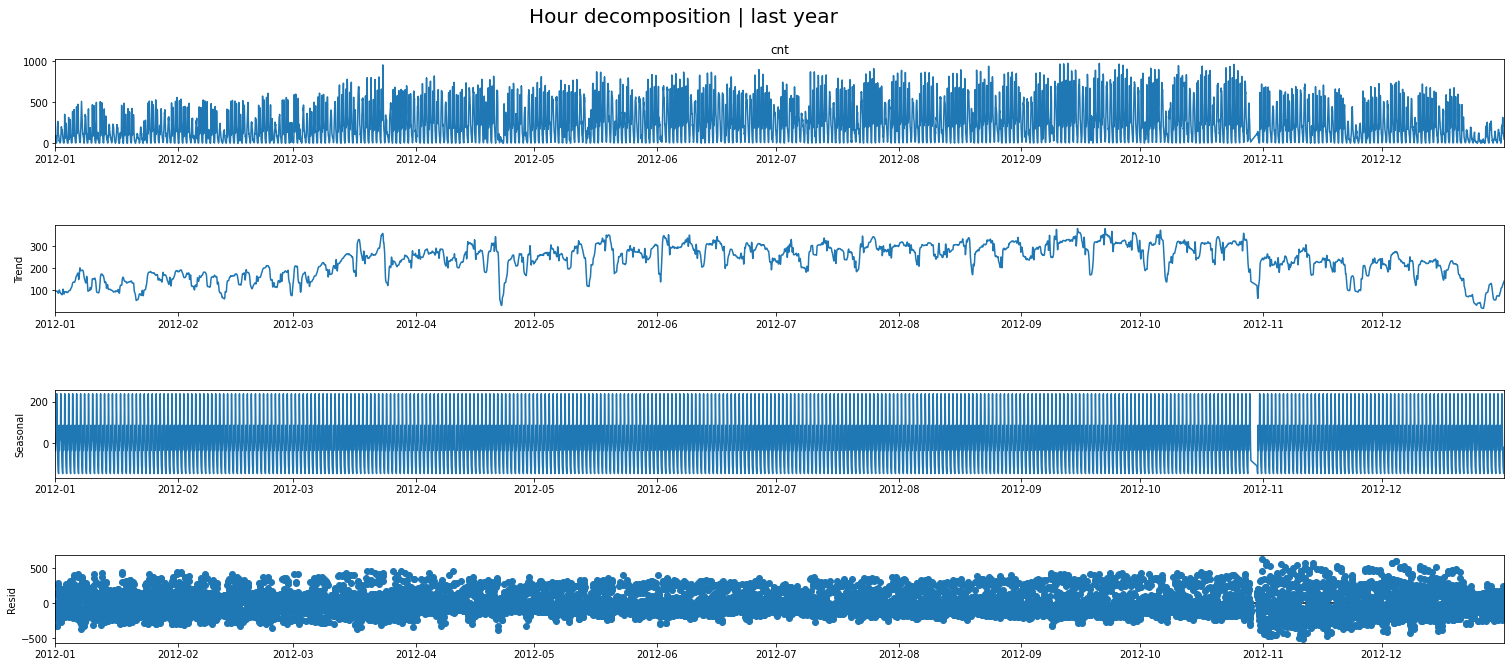

In [ ]:
_, _ = decompose(data[data.index>='2012']["cnt"], period=24, title='Hour decomposition | last year')

Let's look at the last month (test subset).

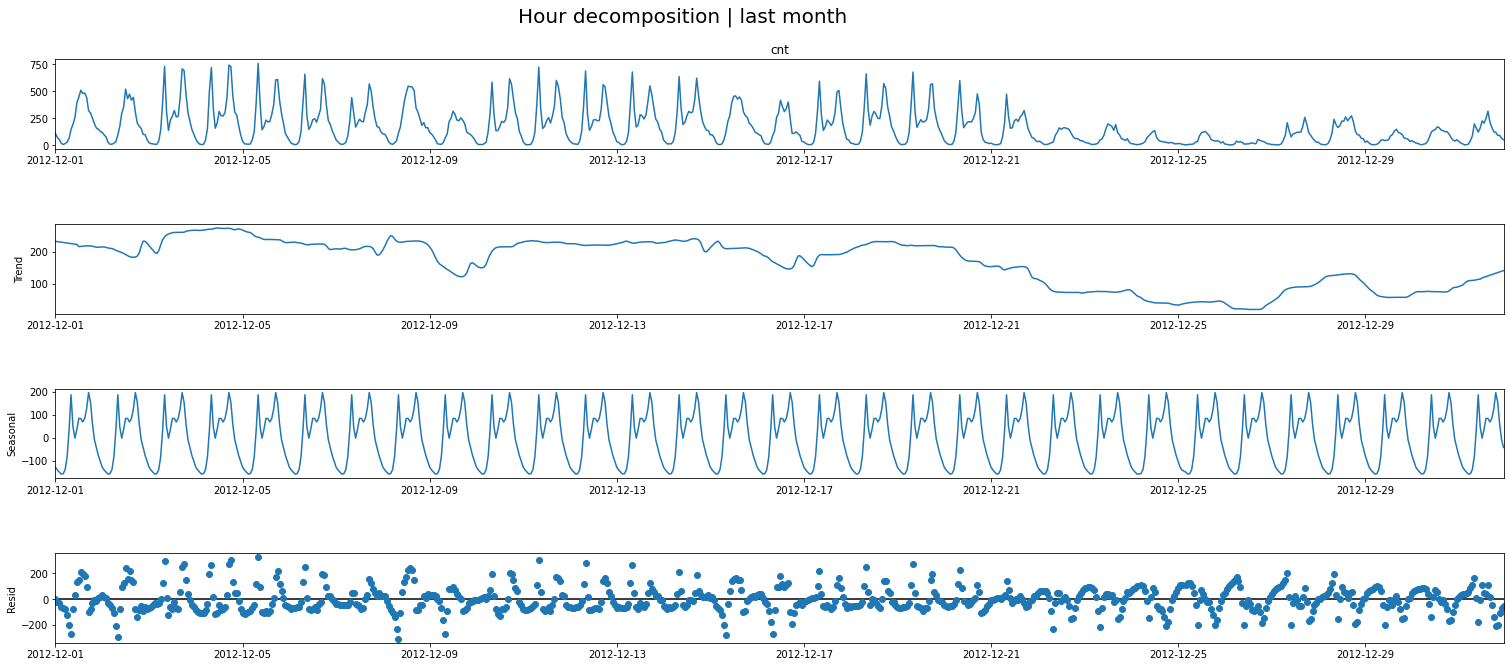

In [ ]:
_, _ = decompose(data[data.index>='2012-12']["cnt"], period=24, title='Hour decomposition | last month')

Now I'd like to see if the population from a year ago has a similar pattern.

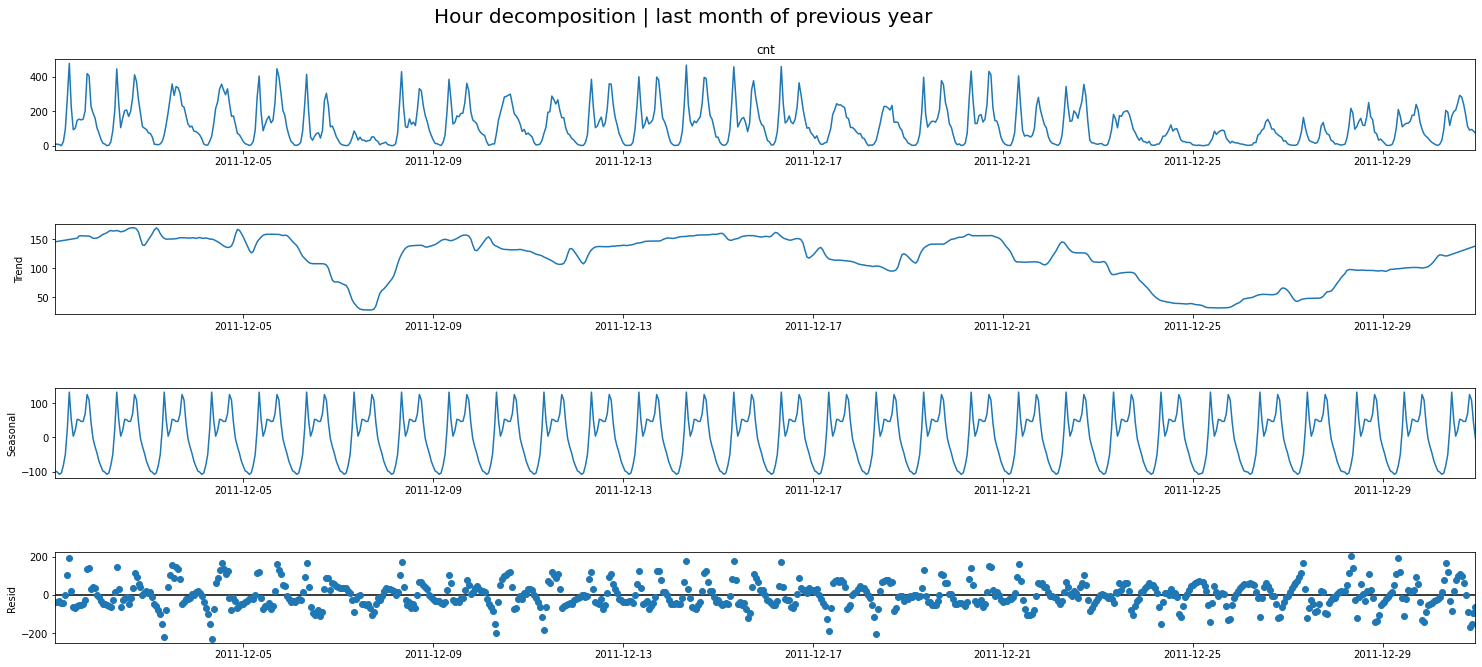

In [ ]:
_, _ = decompose(data[(data.index > '2011-12-1') & (data.index < '2011-12-31')]["cnt"], period=24, title='Hour decomposition | last month of previous year')

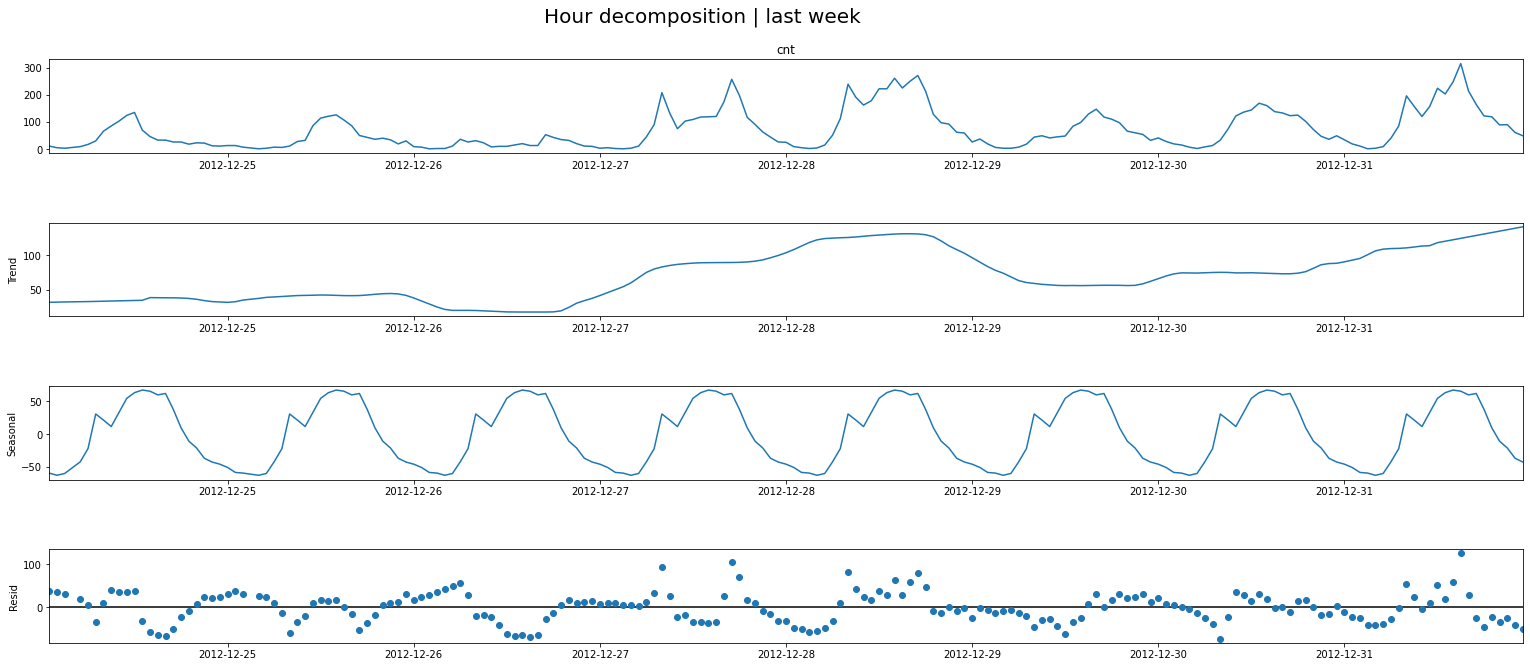

In [ ]:
_, _ = decompose(data[data.index > '2012-12-24']['cnt'], period=24, title='Hour decomposition | last week')

We can assume that the data has a period equal to a day.

Let's form a new dataframe that represents the daily number of bikes rented.

In [ ]:
# get daily rides
daily_rides = df[["dteday", "cnt"]]
daily_rides = daily_rides.groupby("dteday").sum()

# convert index to DateTime object
daily_rides.index = pd.to_datetime(daily_rides.index)
daily_rides

cnt
dteday          
2011-01-01   985
2011-01-02   801
2011-01-03  1349
2011-01-04  1562
2011-01-05  1600
...          ...
2012-12-27  2114
2012-12-28  3095
2012-12-29  1341
2012-12-30  1796
2012-12-31  2729

[731 rows x 1 columns]

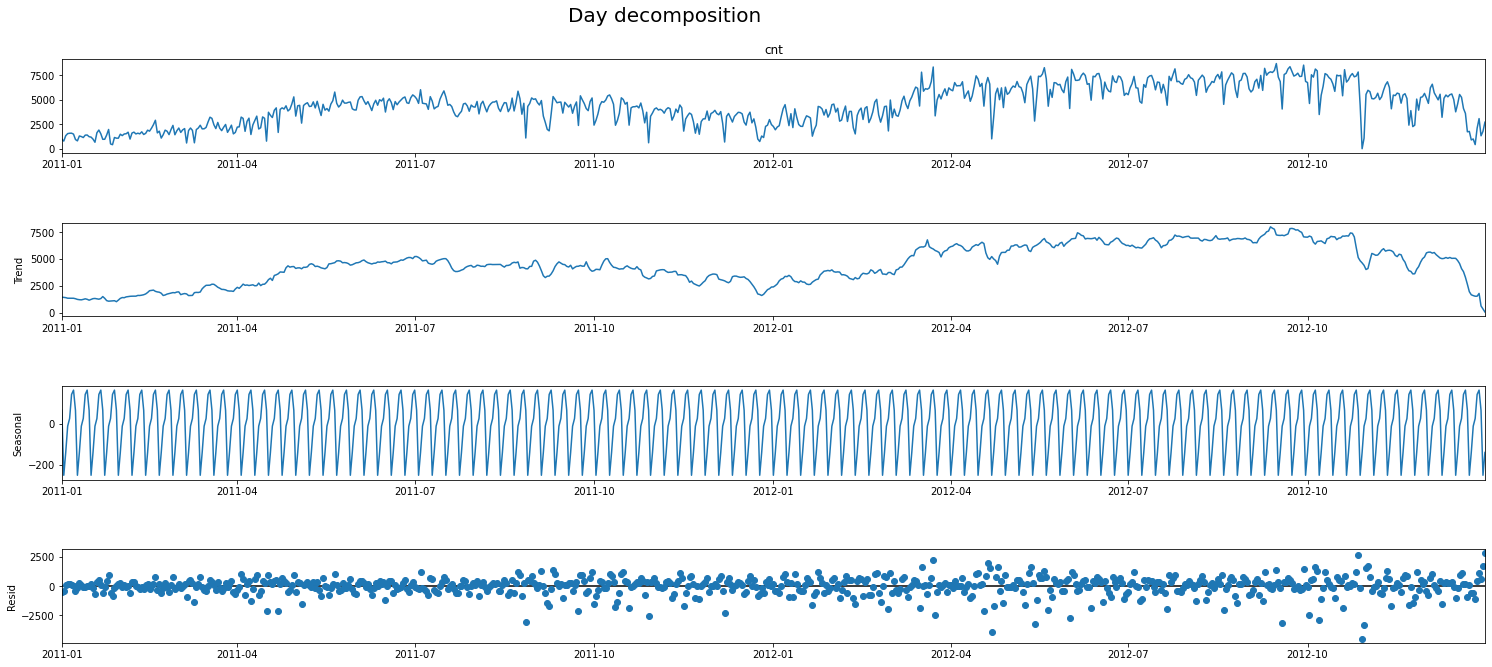

In [ ]:
daily_trend, daily_seasonal = decompose(daily_rides["cnt"], title='Day decomposition')

I suppose we have weekly periods so let's group the data by weeks.

In [ ]:
def find_week(value):
  return int((value.week / 24 + 6) / 7)

weekly_rides = df[['dteday', 'weekday', 'cnt']]
weekly_rides['week'] = range(0,len(weekly_rides))

weekly_rides['week'] = weekly_rides.apply(find_week, axis=1)
weekly_rides.drop(columns=['dteday', 'weekday'], inplace=True)
weekly_rides = weekly_rides.groupby('week').sum()
weekly_rides

cnt
week       
0       985
1      9442
2      8910
3      9661
4      9418
...     ...
100   39102
101   35450
102   29359
103   10818
104    4671

[105 rows x 1 columns]

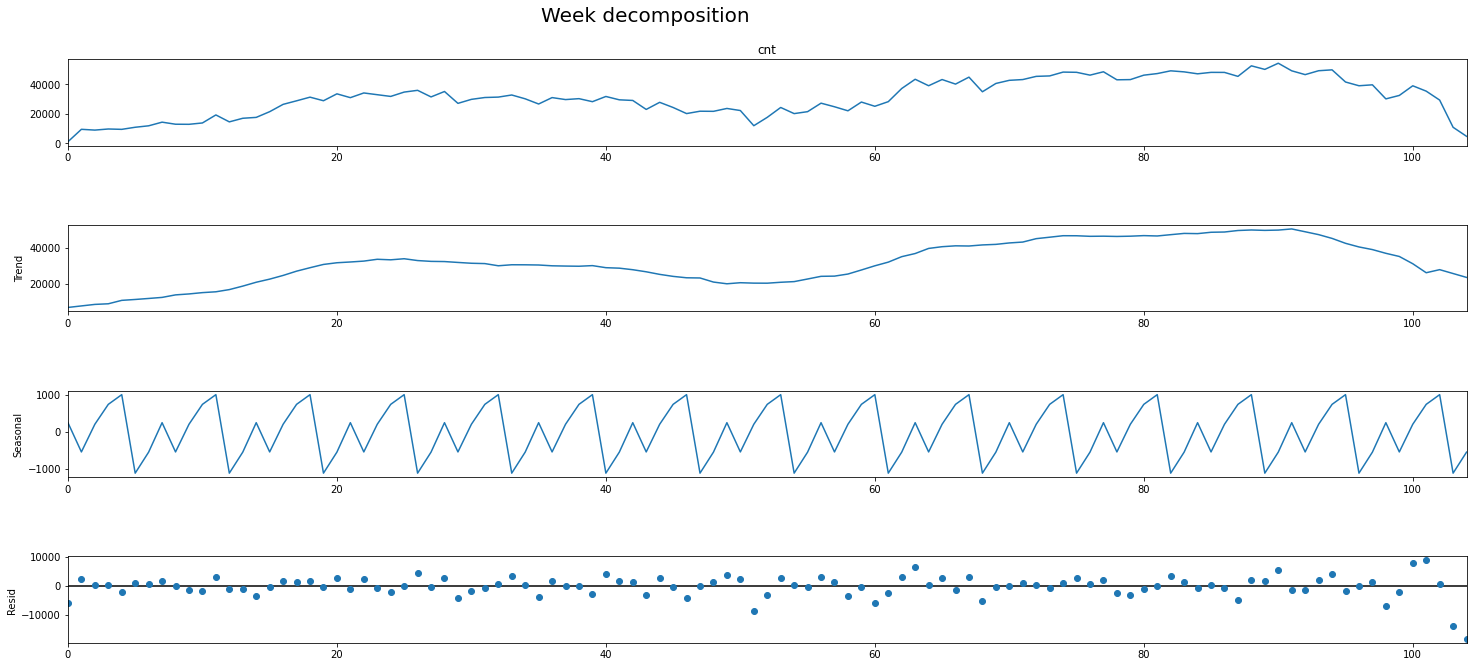

In [ ]:
weekly_trend, weekly_seasonal = decompose(weekly_rides["cnt"], period=7, title='Week decomposition')

Now let's create monthly data.

In [ ]:
df['yymm'] = (df['yr'] * 12) + df['mnth']
df['yymm'] = df['yymm'].astype(int)

In [ ]:
# get monthly rides
monthly_rides = df[["cnt", 'yymm']]
monthly_rides = monthly_rides.groupby("yymm").sum()

# convert index to DateTime object
#monthly_rides.index = pd.to_datetime(monthly_rides.index)

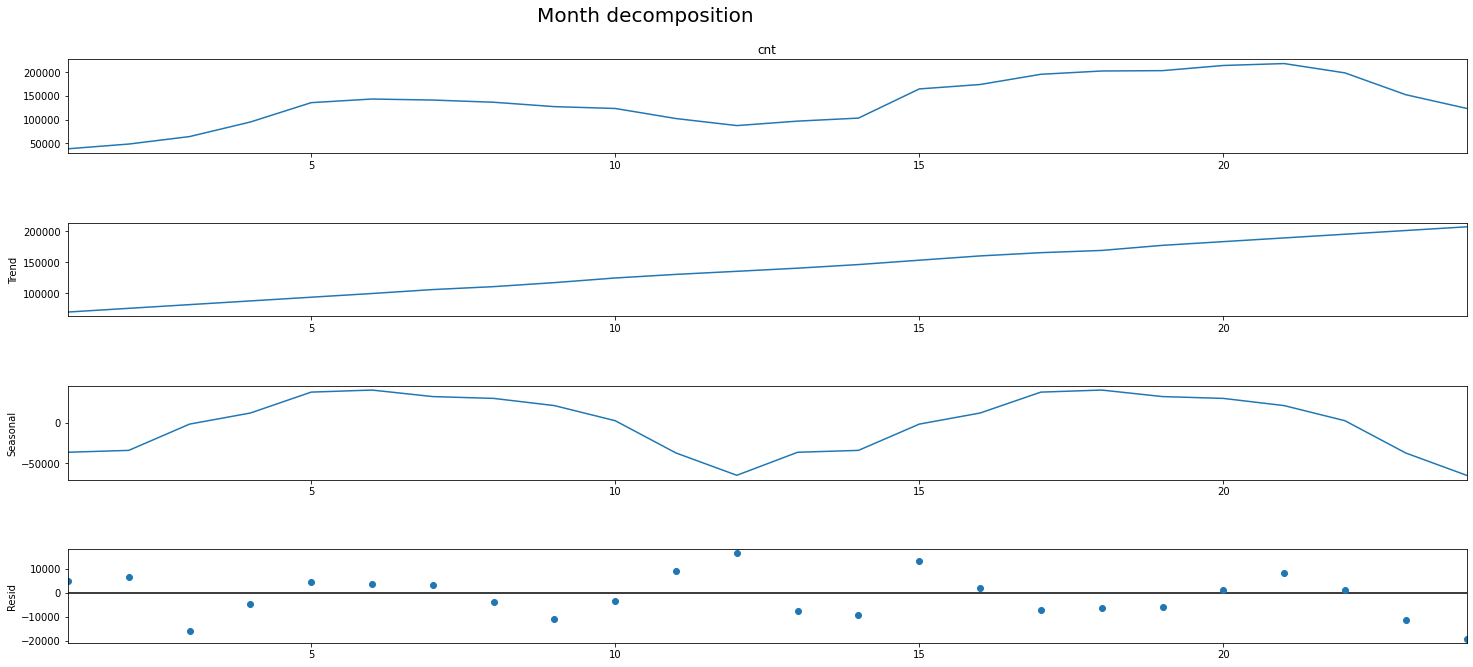

In [ ]:
montly_trend, monthly_seasonal = decompose(monthly_rides["cnt"], period=12, title='Month decomposition')

<AxesSubplot:xlabel='mnth', ylabel='cnt'>

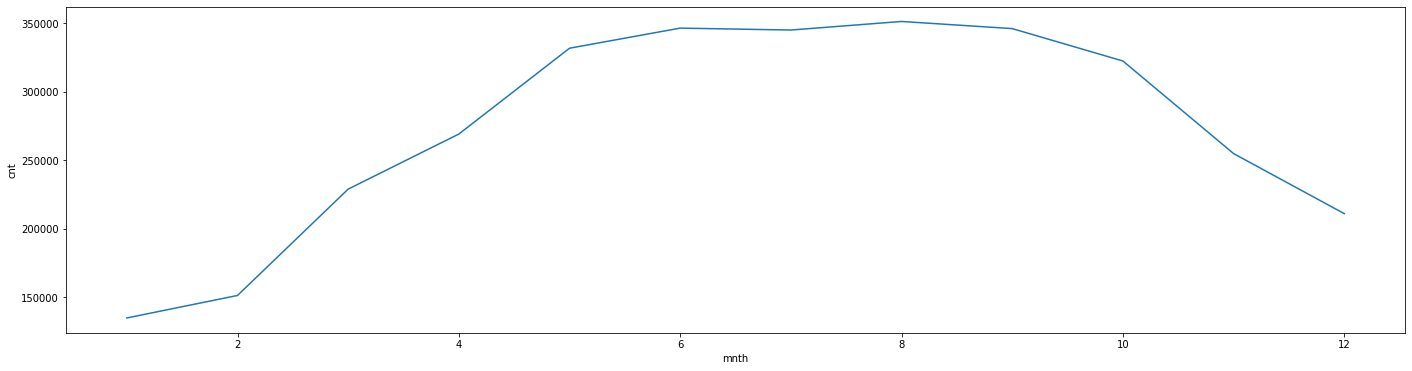

In [ ]:
plt.figure(figsize=(24,6))
monthes = df[['mnth', 'cnt']].groupby('mnth').sum()
sns.lineplot(x=monthes.index, y=monthes['cnt'])

<AxesSubplot:xlabel='weekday', ylabel='cnt'>

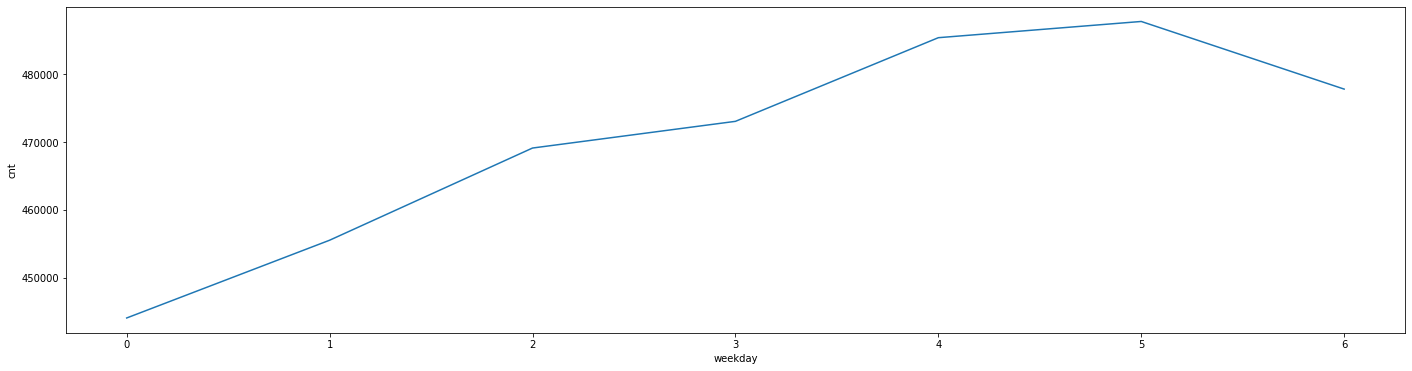

In [ ]:
plt.figure(figsize=(24,6))
weekdays = df[['weekday', 'cnt']].groupby('weekday').sum()
sns.lineplot(x=weekdays.index, y=weekdays['cnt'])

<AxesSubplot:xlabel='hr', ylabel='cnt'>

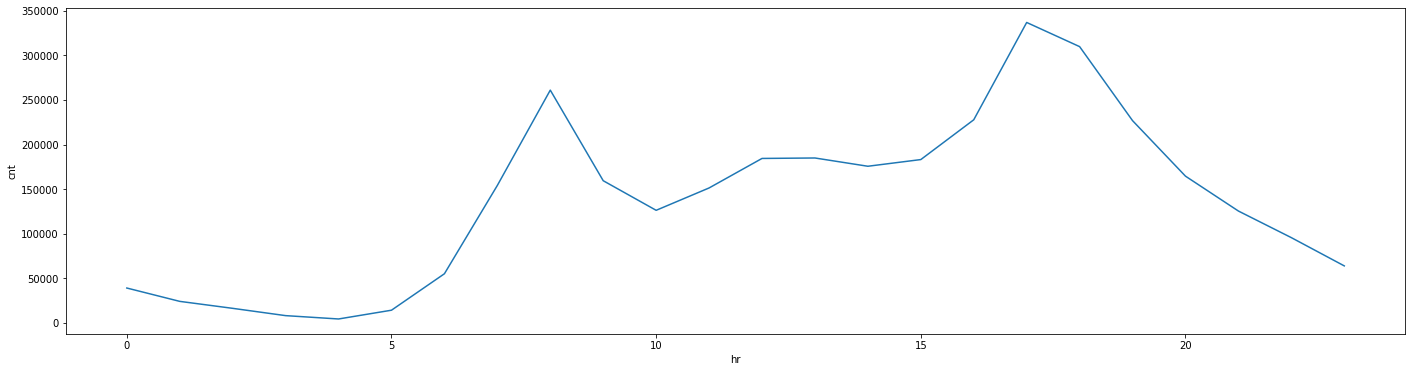

In [ ]:
plt.figure(figsize=(24,6))
hours = df[['hr', 'cnt']].groupby('hr').sum()
sns.lineplot(x=hours.index, y=hours['cnt'])

We see that the number of rented bicycles depends on the month: probably, most often bicycles are rented during the warm season. We can also see the dependency between hour and `cnt`. The day of the week can also affect the target. The number of bikes rented tends to increase over the years. So, we have the following periods: day, week, year.

##Correlation analysis

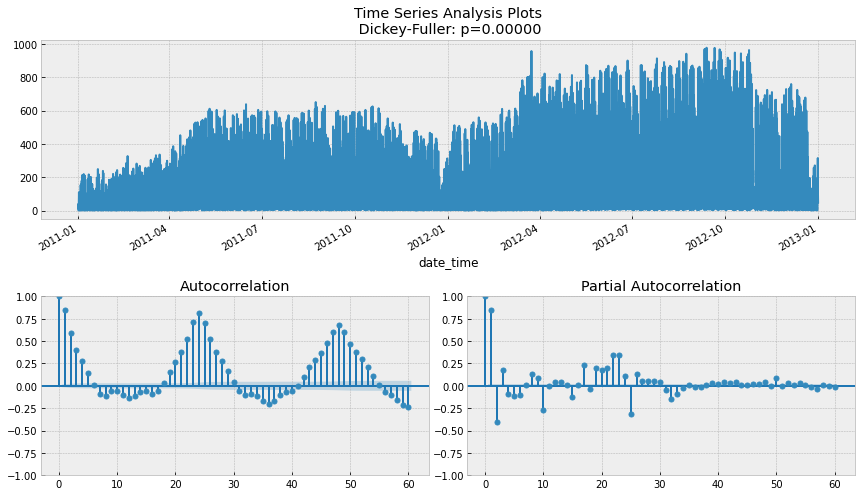

In [ ]:
tsplot(data['cnt'], lags=60)

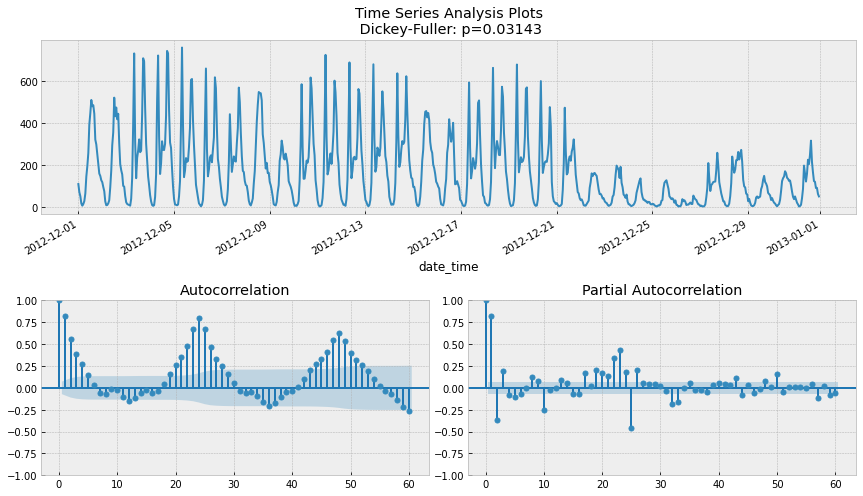

In [ ]:
tsplot(data[data.index>='2012-12']['cnt'], lags=60)

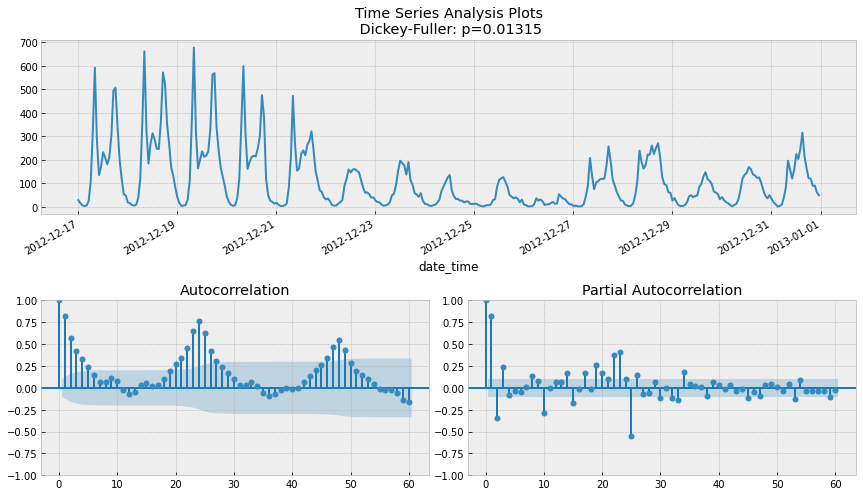

In [ ]:
tsplot(data[data.index>='2012-12-17']['cnt'], lags=60)

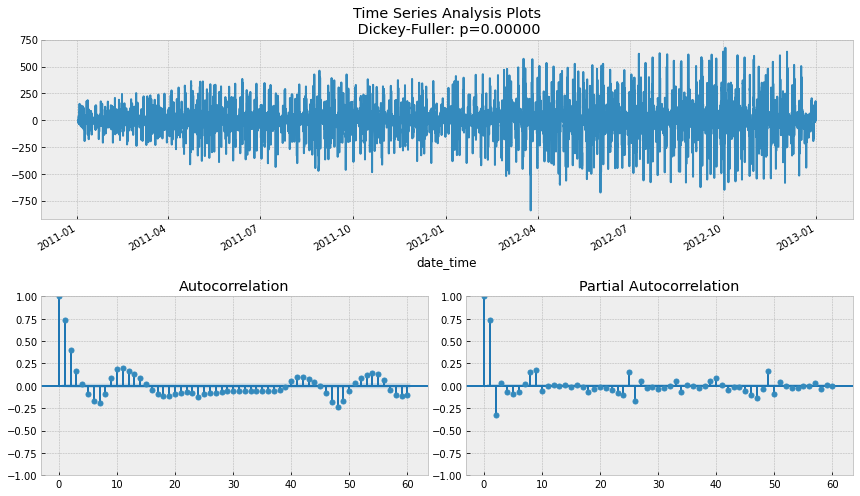

In [ ]:
rides_diff = data.cnt - data.cnt.shift(24)
tsplot(rides_diff[24:], lags=60)

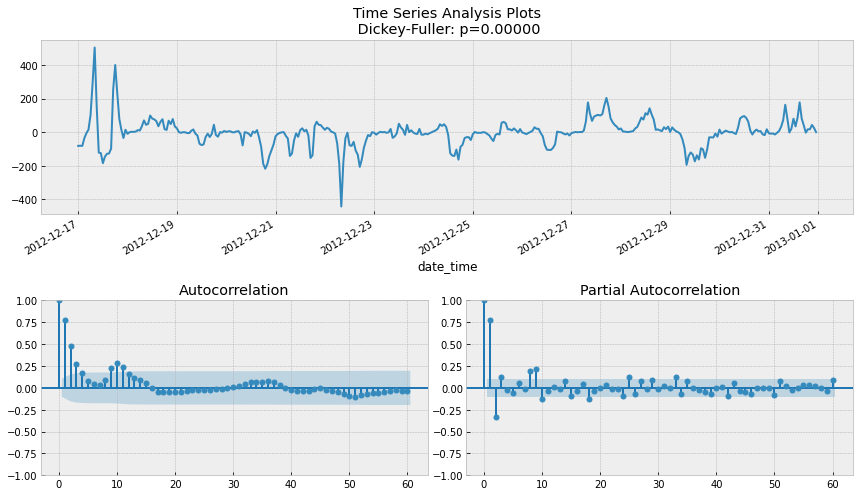

In [ ]:
tsplot(rides_diff[rides_diff.index>='2012-12-17'], lags=60)

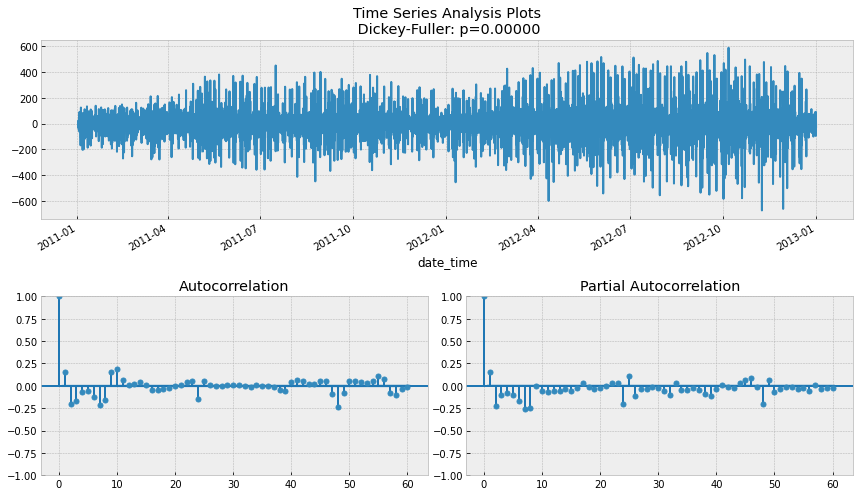

In [ ]:
rides_diff2 = rides_diff - rides_diff.shift(1)
tsplot(rides_diff2[24+1:], lags=60)

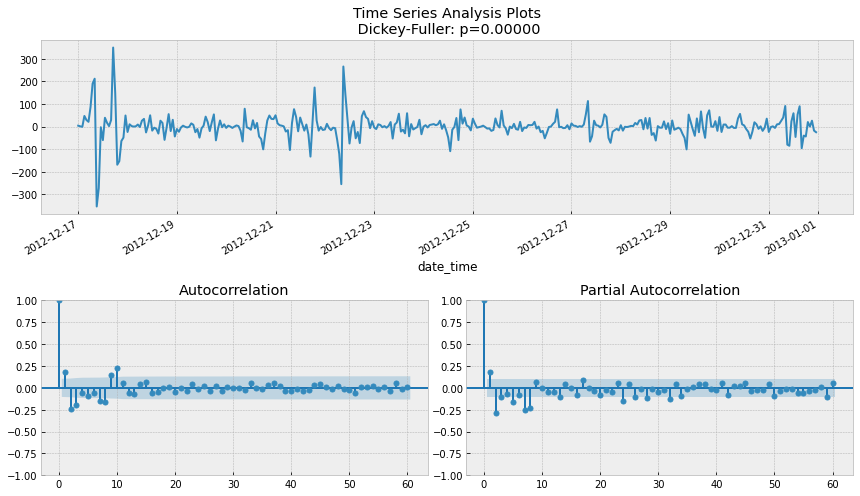

In [ ]:
tsplot(rides_diff2[rides_diff2.index>='2012-12-17'], lags=60)

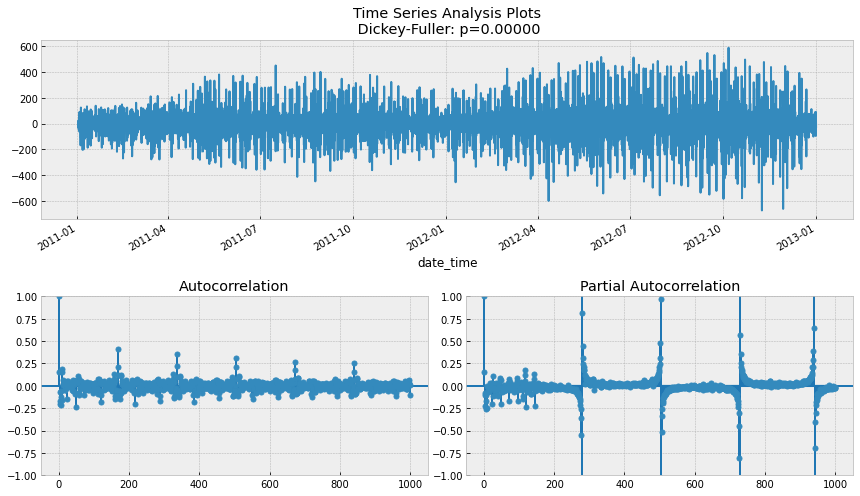

In [ ]:
tsplot(rides_diff2.dropna(), lags=1000)

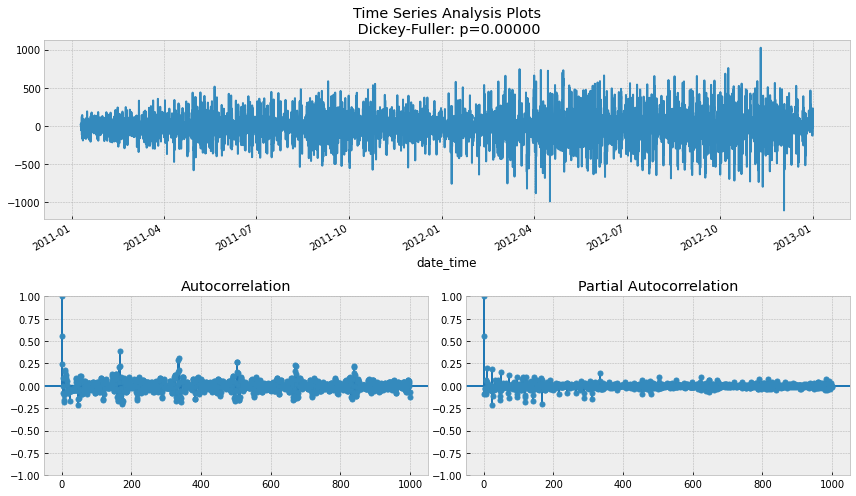

In [ ]:
rides_diff3 = rides_diff2 - rides_diff.shift(168)
tsplot(rides_diff3[24+1+168:], lags=1000)

<AxesSubplot:xlabel='date_time', ylabel='cnt'>

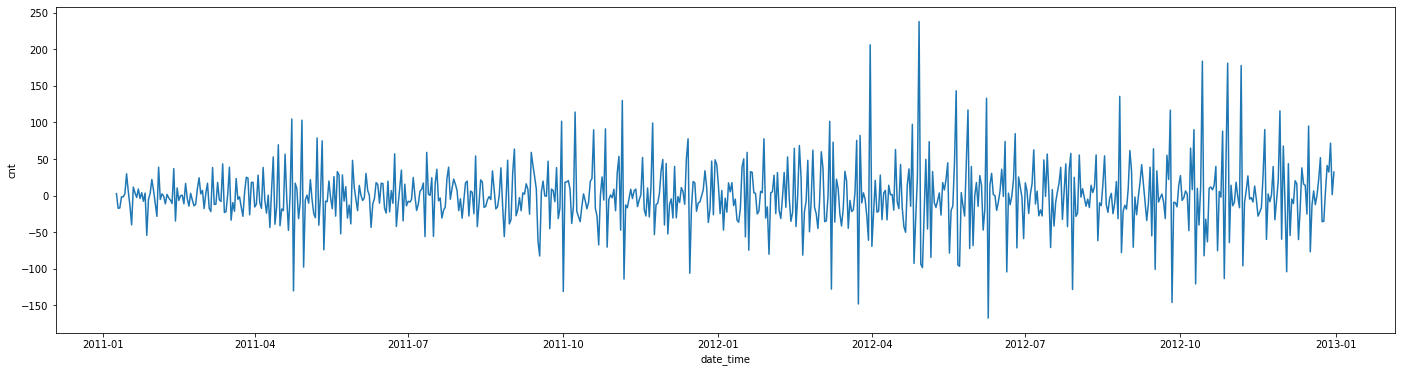

In [ ]:
plt.figure(figsize=(24,6))
sns.lineplot(data=rides_diff3.resample('D').mean())

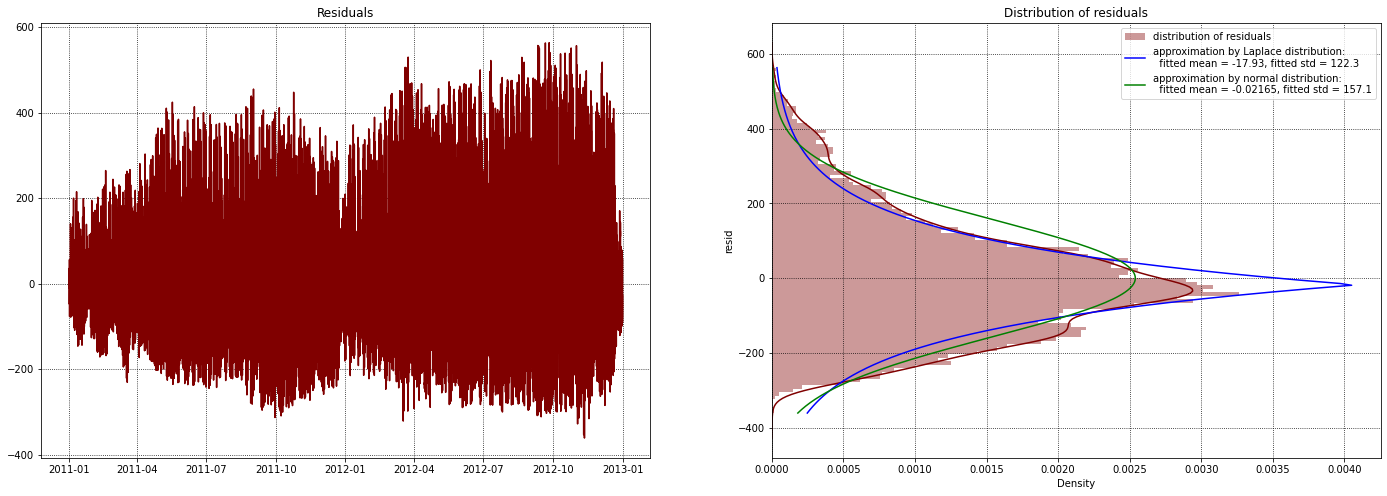

In [ ]:
resid = seasonal_decompose(data["cnt"], period=24).resid
color = 'maroon'

plt.subplots(1, 2, figsize=(24, 8))

plt.subplot(1, 2, 1)
plt.plot(resid, '-', color=color)
plt.grid(linestyle=':', color='k')
plt.title("Residuals")



x_fit = np.linspace(resid.min(), resid.max(), 201)
loc_laplace, scale_laplace = st.laplace.fit(resid.dropna())
loc_norm, scale_norm = st.norm.fit(resid.dropna())
# print(f"Fitting of residuals by Laplace distribution: fitted mean = {loc:.3f}, fitted std = {scale:.3f}")
y_fit_laplace = st.laplace.pdf(x_fit, loc_laplace, scale_laplace)
y_fit_norm = st.norm.pdf(x_fit, loc_norm, scale_norm)

plt.subplot(1, 2, 2)
sns.distplot(resid, color=color, bins=100, vertical=True, label="distribution of residuals")
plt.plot(y_fit_laplace, x_fit, '-b',
         label=f"approximation by Laplace distribution:\n  fitted mean = {loc_laplace:.4g}, fitted std = {scale_laplace:.4g}")
plt.plot(y_fit_norm, x_fit, '-g',
         label=f"approximation by normal distribution:\n  fitted mean = {loc_norm:.4g}, fitted std = {scale_norm:.4g}")
plt.legend()
# plt.ylim(resid-0.02*y_range, y_max+0.02*y_range)
plt.title("Distribution of residuals")
plt.grid(linestyle=':', color='k')

plt.show()

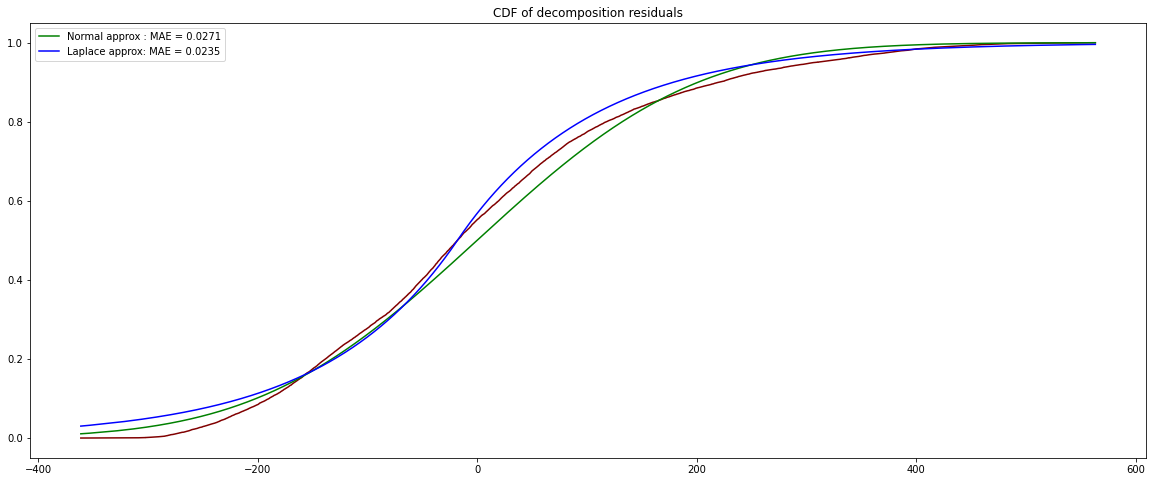

MAE_Gaussian/MAE_Laplace = 1.15.


In [ ]:
ecdf_resid_instance = ECDF(resid.dropna())
resid_arr = resid.dropna().sort_values().values
ecdf_resid = ecdf_resid_instance(resid_arr)


cdf_norm = st.norm.cdf(resid_arr, loc=loc_norm, scale=scale_norm)
cdf_laplace = st.laplace.cdf(resid_arr, loc=loc_laplace, scale=scale_laplace)


mae_norm = mean_absolute_error(ecdf_resid, cdf_norm)
mae_laplace = mean_absolute_error(ecdf_resid, cdf_laplace)


plt.subplots(1, 1, figsize=(20, 8))
plt.plot(resid_arr, ecdf_resid, '-', color='maroon')
plt.plot(resid_arr, cdf_norm, '-g',
         label=f"Normal approx : MAE = {mae_norm:.3g}")
plt.plot(resid_arr, cdf_laplace, '-b',
         label=f"Laplace approx: MAE = {mae_laplace:.3g}")
plt.legend()
plt.title("CDF of decomposition residuals")
plt.show()

print(f"MAE_Gaussian/MAE_Laplace = {mae_norm/mae_laplace:.3g}.")

##Tests for stationarity

In [ ]:
def test_stationarity(data, alpha=0.05):
  print(f"alpha = {alpha}\n")
  # ADF Test
  print("==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): ")
  result = adfuller(data.dropna(), autolag='AIC')
  print(f'ADF Statistic: {result[0]:.4g}')
  print(f'p-value: {result[1]:.4g}')
  if result[1] < alpha:
      print("The process is stationary.\n")
  else:
      print("The process is non-stationary.\n")

  print('==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):')
  # kpss test
  kpsstest = kpss(data.dropna(), regression='c')
  print(f"KPSS Statistic = {kpsstest[0]:.4g}")
  print(f"p-value = {kpsstest[1]:.4g}")
  if kpsstest[1] < alpha:
      print("The process is non-stationary.\n")
  else:
      print("The process is stationary.\n")

In [ ]:
hour_trend = seasonal_decompose(data["cnt"], period=24).trend.dropna()
test_stationarity(hour_trend)

alpha = 0.05

==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): 
ADF Statistic: -5.324
p-value: 4.89e-06
The process is stationary.

==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):
KPSS Statistic = 11.23
p-value = 0.01
The process is non-stationary.



Text(0.5, 1.0, '1st derivative of trend')

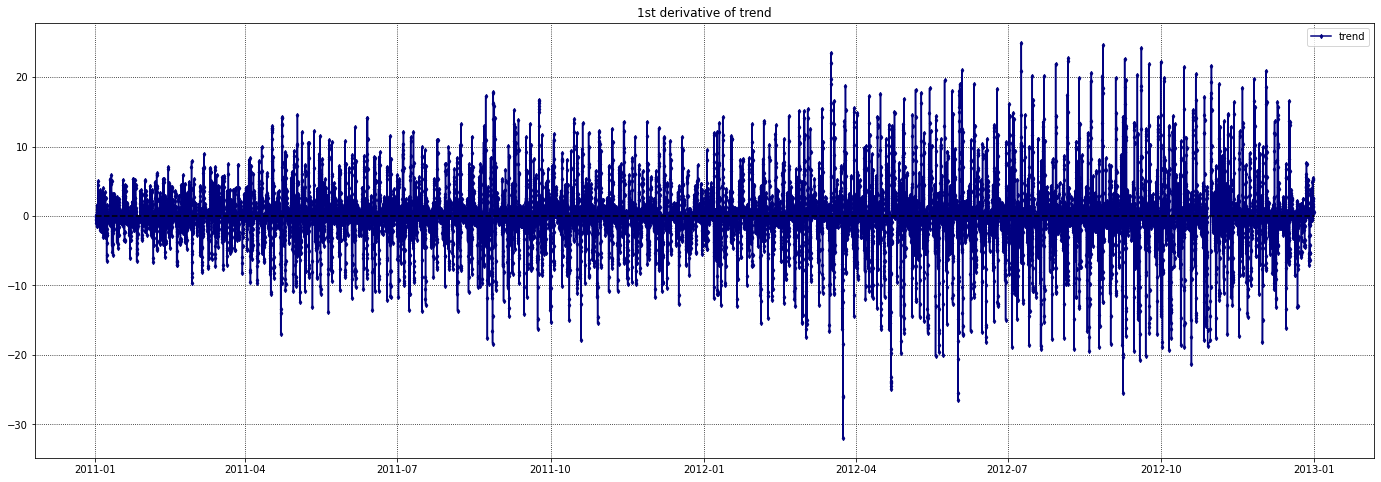

In [ ]:
hour_trend_diff = hour_trend.diff().dropna()

plt.subplots(1, 1, figsize=(24, 8))

plt.plot(hour_trend_diff, '-d', color='navy', markersize=3, label='trend')
plt.plot([hour_trend_diff.index[0], hour_trend_diff.index[-1]], [0, 0], '--k')
plt.legend()
plt.grid(linestyle=':', color='k')
plt.title("1st derivative of trend")

In [ ]:
test_stationarity(hour_trend_diff)

alpha = 0.05

==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): 
ADF Statistic: -24.4
p-value: 0
The process is stationary.

==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):
KPSS Statistic = 0.01405
p-value = 0.1
The process is stationary.



In [ ]:
test_stationarity(rides_diff3)

alpha = 0.05

==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): 
ADF Statistic: -22
p-value: 0
The process is stationary.

==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):
KPSS Statistic = 0.03494
p-value = 0.1
The process is stationary.



#LinearRegression

##Endogenous features

In [ ]:
# for time-series cross-validation set 5 folds
tscv = TimeSeriesSplit(n_splits=5)

To form X dataset we first take the features engineered from time.

In [ ]:
y = data.dropna().cnt
X = df[['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday']]
X.index = pd.to_datetime(data.index)

Using the results of EDA, we can add new features to our model - lags. Considering the fact that the model must predict values one month ahead, I will take the 840th (5 weeks ago) and 168th lag (a week ago) and make predictions week by week.

In [ ]:
X["lag_840"] = data.cnt.shift(840)
X["lag_168"] = data.cnt.shift(168)
X.dropna(inplace = True)

Now we can form the train and test datasets.

In [ ]:
def train_test_split(X, y):
  X_train, X_test = X[X.index < '2012-12-1'], X[X.index >= '2012-12-1']
  y_train, y_test = y[X_train.index], y[X_test.index]

  return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

To make week-by-week predictions I'll divide the test dataset into parts.

In [ ]:
def split_predict_by_period(model, X_test, y_test, period):
  X_tests = [X_test[x:x+period] for x in range(0, len(X_test), period)]
  preds = []
  for i in range(0,len(X_tests)):
    pred = model.predict(X_tests[i])
    if i < len(X_tests)-1:
      X_tests[i+1][f'lag_{period}'] = pred[:len(X_tests[i+1])]
    for val in pred:
      preds.append(val)

  return preds

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
preds = split_predict_by_period(lr, X_test, y_test, 168)

In [ ]:
def plot_predictions(preds, y_test):
  plt.figure(figsize=(15, 7))
  plt.plot(preds, "g", label="prediction", linewidth=2.0)
  plt.plot(y_test.values, label="actual", linewidth=2.0)

  error = mean_absolute_error(preds, y_test)
  plt.title(f"Mean absolute error {error}")
  plt.legend(loc="best")
  plt.tight_layout()
  plt.grid(True);
  plt.show()

  errors = y_test - preds

  plt.subplots(1, 2, figsize=(24, 8))

  plt.subplot(1, 2, 1)
  sns.lineplot(preds,errors, color='r').set(title='Residual')
  plt.grid(linestyle=':')
  plt.title("Residuals")

  plt.subplot(1, 2, 2)
  sns.distplot(errors, bins=100, vertical=True, label="distribution of residuals")
  plt.title("Distribution of residuals")
  plt.grid(linestyle=':')

  plt.show()

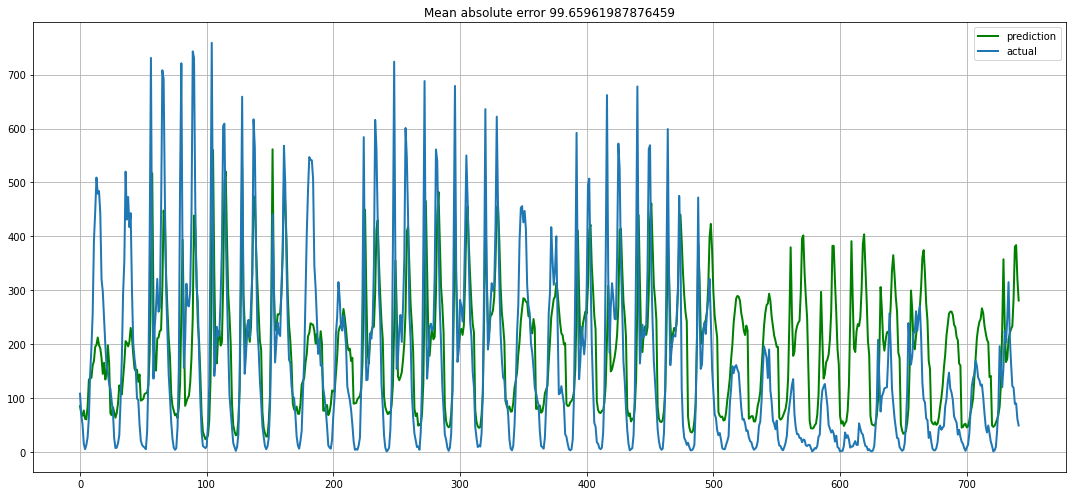

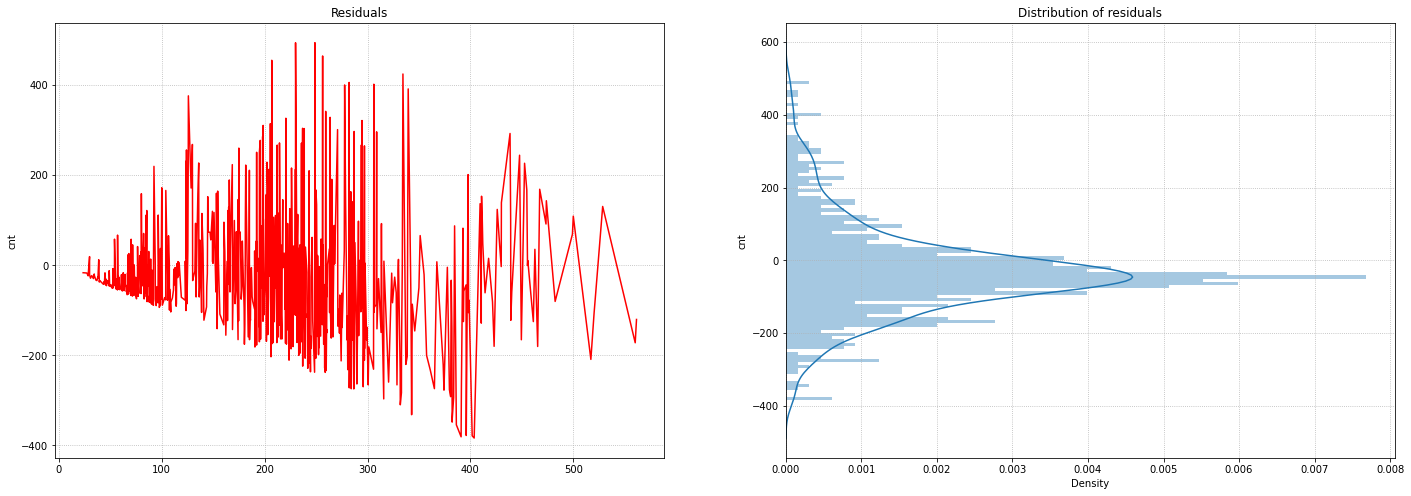

In [ ]:
plot_predictions(preds, y_test)

##Adding exogenous features

In [ ]:
X_ext = X.copy()
X_ext[['weathersit', 'temp', 'hum', 'windspeed']] = df[:-840][['weathersit', 'temp', 'hum', 'windspeed']].to_numpy()

In [ ]:
X_ext_train, X_ext_test, y_train, y_test = train_test_split(X_ext, y)

In [ ]:
lr_ext = LinearRegression()
lr_ext.fit(X_ext_train, y_train)

LinearRegression()

In [ ]:
preds_ext = split_predict_by_period(lr_ext, X_ext_test, y_test, 168)

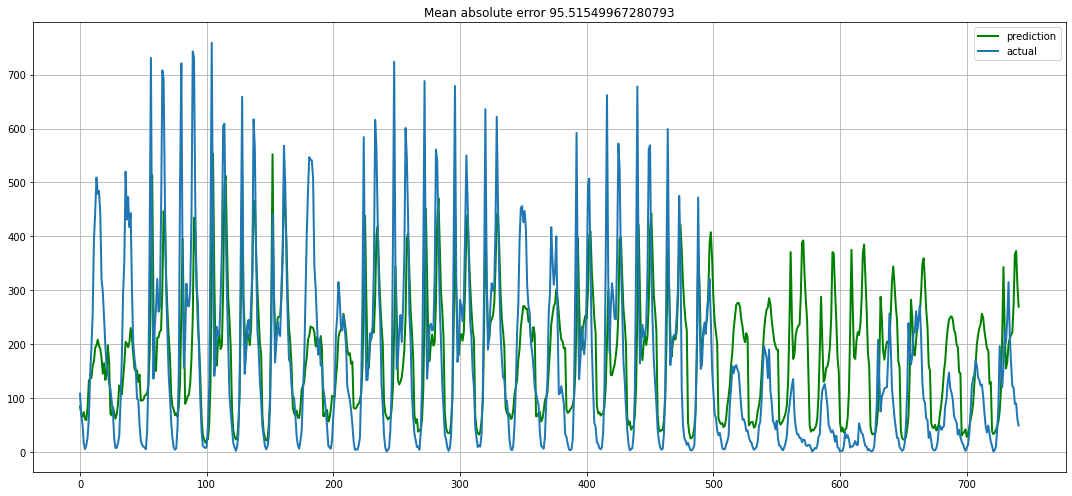

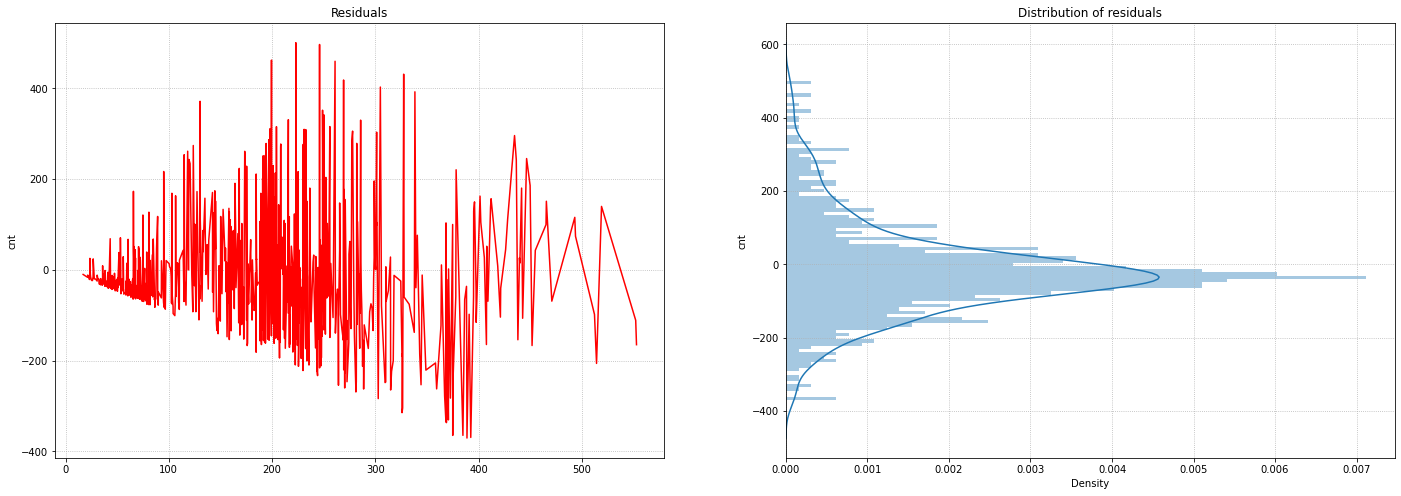

In [ ]:
plot_predictions(preds_ext, y_test)

##Additional feature, day-by-day prediction

In [ ]:
X_new = X_ext.copy()
X_new["lag_24"] = data.cnt.shift(24)
X_new.dropna(inplace = True)

In [ ]:
X_new_train, X_new_test, y_train, y_test = train_test_split(X_new, y)

In [ ]:
lr = LinearRegression()
lr.fit(X_new_train, y_train)

LinearRegression()

In [ ]:
X_new_tests = [X_new_test[x:x+168] for x in range(0, len(X_new_test), 168)]
predsss = []

for i in range(0, len(X_new_tests)):

  X_new_tests_small = [X_new_tests[i][x:x+24] for x in range(0, len(X_new_tests[i]), 24)]

  preds = []
  for j in range(0,len(X_new_tests_small)):
    pred = lr.predict(X_new_tests_small[j])
    if j < 6 and i < 4 :
      X_new_tests_small[j+1][f'lag_24'] = pred[:len(X_new_tests_small[j+1])]
    for val in pred:
      preds.append(val)

  predsss.append(preds)

In [ ]:
predsss = [item for sublist in predsss for item in sublist]

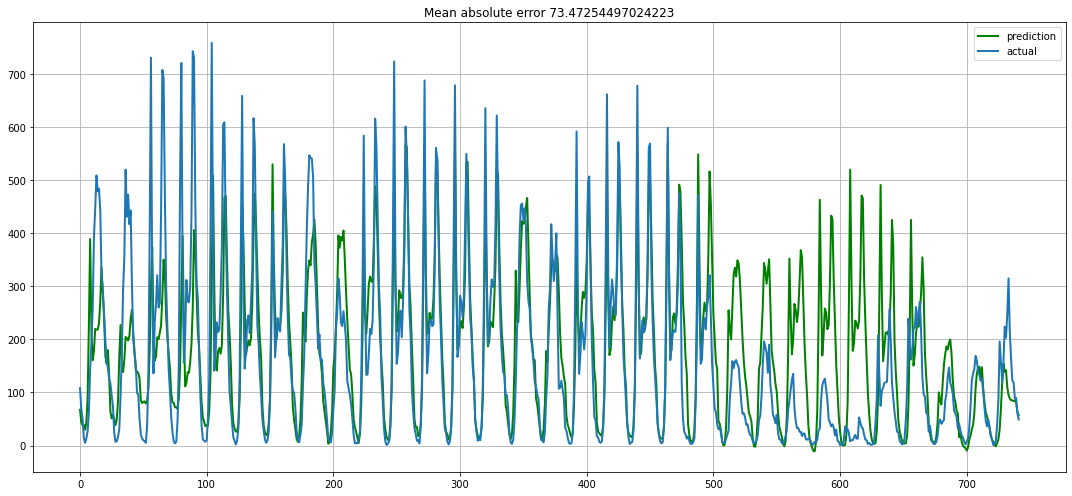

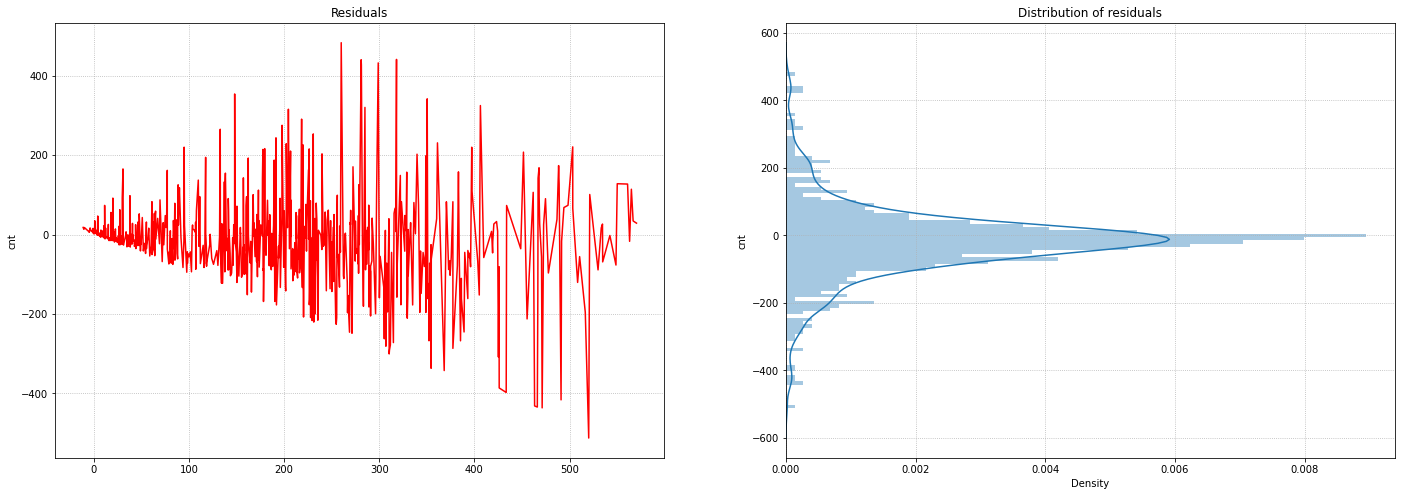

In [ ]:
plot_predictions(predsss, y_test)

#ARIMA

In [ ]:
N_test = 742
print(f"We have {len(data)} points totally and last {N_test} test points amongst them.")

train_ind = np.arange(len(data)-N_test)
test_ind = np.arange(len(data)-N_test, len(data))

train = data.iloc[train_ind, :]['cnt']
test = data.iloc[test_ind, :]['cnt']

We have 17379 points totally and last 742 test points amongst them.


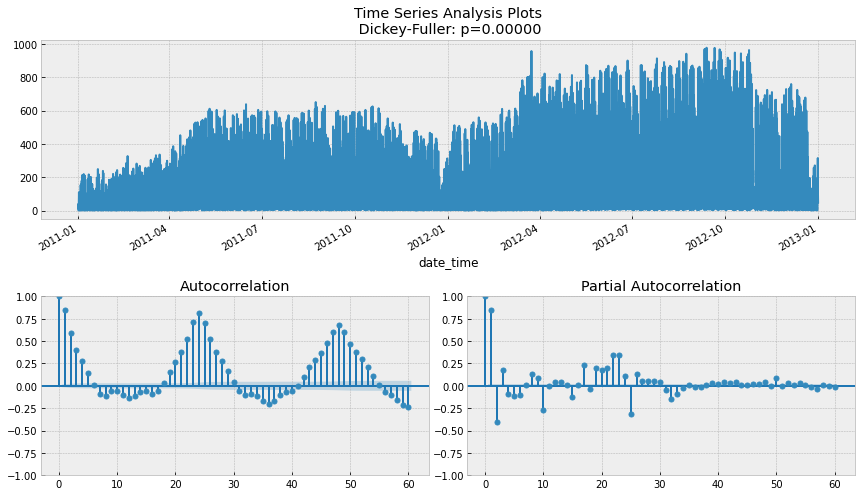

In [ ]:
tsplot(data.cnt, lags=60)

Here I'll apply log10 transformation since it helps with stationarity.

d = 1 as we've differentiated once, q = 5 as the number of points hardly out of significance limit, p = 1 as lag #1 is the most valuable.

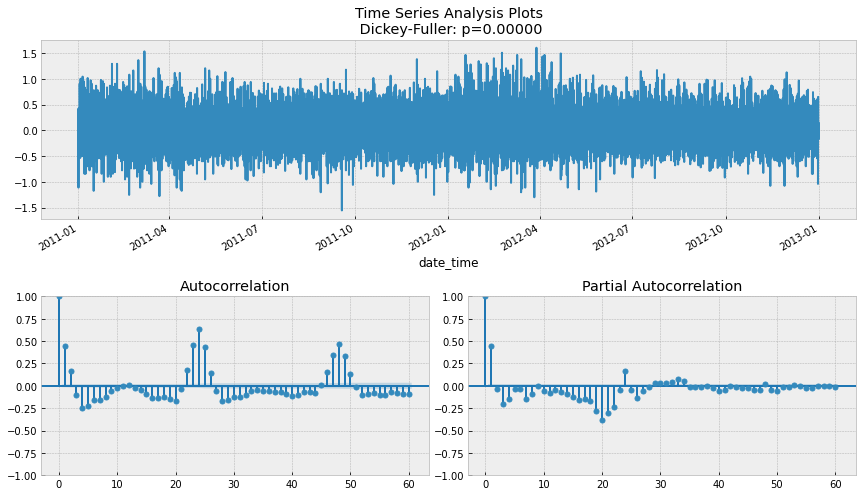

In [ ]:
tsplot(np.log10(data.cnt).diff().dropna(), lags=60)

ARIMA model (1, 1, 5):
                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                16637
Model:                 ARIMA(1, 1, 5)   Log Likelihood                -245.740
Date:                Tue, 14 Mar 2023   AIC                            505.481
Time:                        20:23:38   BIC                            559.516
Sample:                             0   HQIC                           523.319
                              - 16637                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4982      0.016     32.038      0.000       0.468       0.529
ma.L1         -0.2038      0.017    -11.649      0.000      -0.238      -0.169
ma.L2         -0.0865      0.

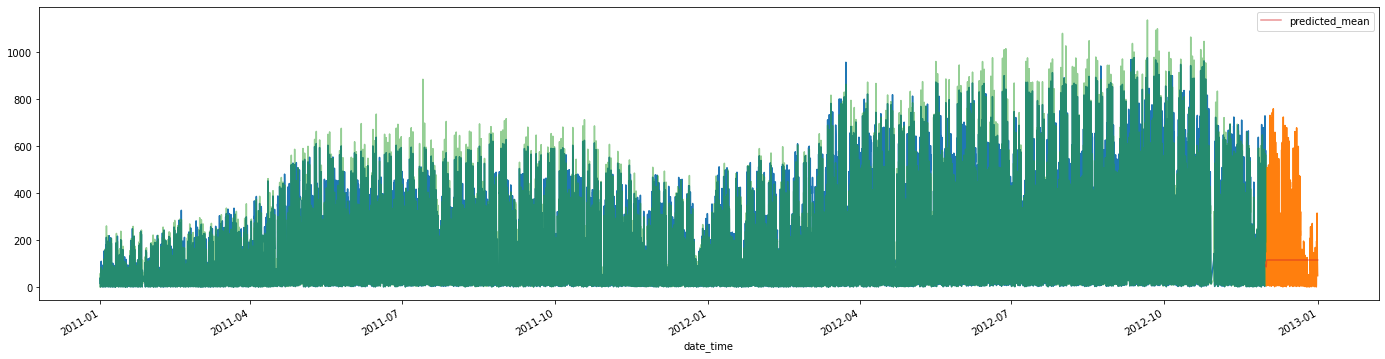

In [ ]:
_ = train_test_arima(1, 1, 5, 742, train, test, np.log10, lambda data: 10 ** data)

We got bad results. It's predictable since ARIMA doesn't support time series with a seasonal component. Let's try `auto_arima` to find parameters.

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                17379
Model:               SARIMAX(4, 0, 6)   Log Likelihood                 -91.212
Date:                Tue, 14 Mar 2023   AIC                            206.425
Time:                        11:25:15   BIC                            299.581
Sample:                             0   HQIC                           237.111
                              - 17379                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4587      0.038     11.966      0.000       0.384       0.534
ar.L1          0.6508      0.019     33.529      0.000       0.613       0.689
ar.L2         -0.0484      0.021     -2.259      0.0

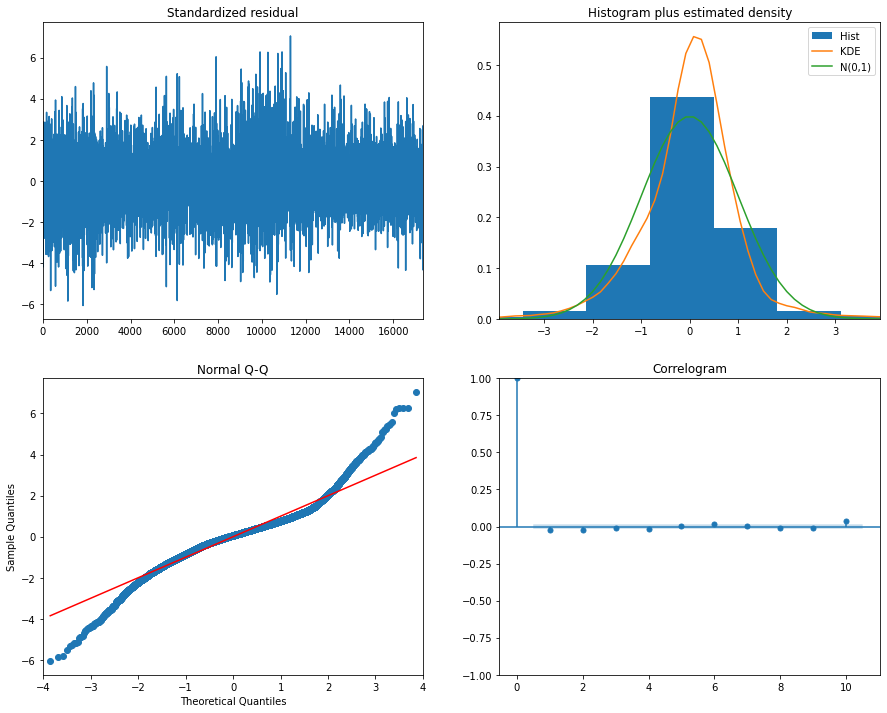

In [ ]:
perform_auto_arima(np.log10(data.cnt))

ARIMA model (4, 0, 6):
                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                16637
Model:                 ARIMA(4, 0, 6)   Log Likelihood                 689.570
Date:                Tue, 14 Mar 2023   AIC                          -1355.140
Time:                        19:22:35   BIC                          -1262.507
Sample:                             0   HQIC                         -1324.561
                              - 16637                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9739      0.011    187.375      0.000       1.953       1.995
ar.L1          1.4172      0.021     68.413      0.000       1.377       1.458
ar.L2          0.4258      0.

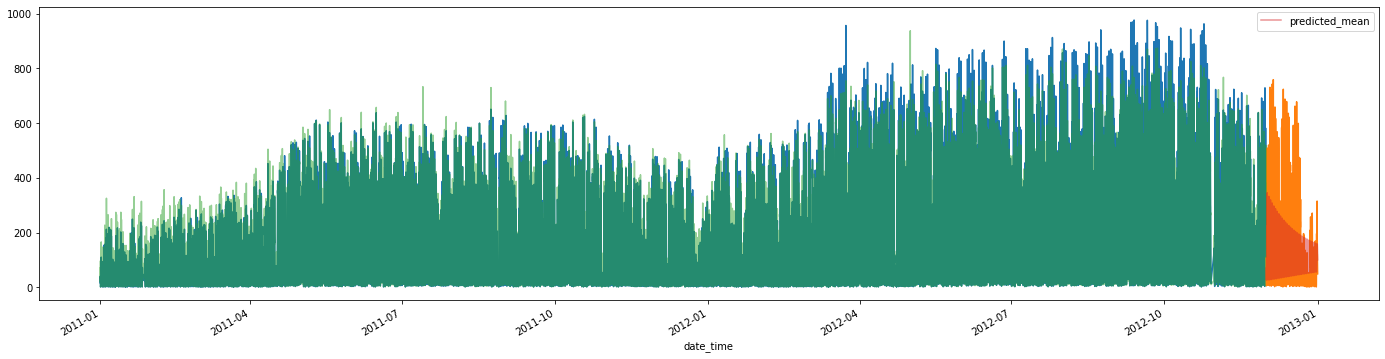

In [ ]:
preds_arima = train_test_arima(4, 0, 6, 742, train, test, np.log10, lambda data: 10 ** data)

MAE reduced.

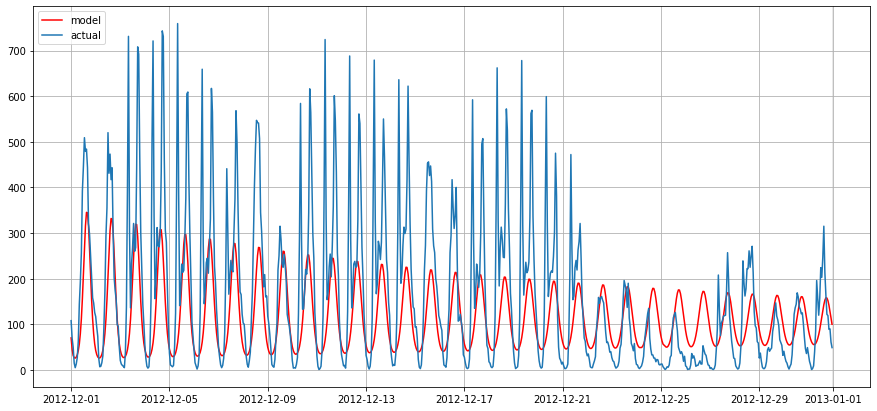

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(preds_arima, color='r', label="model")
plt.axvspan(data.index[-1], preds_arima .index[-1], alpha=0.5, color='lightgrey')
plt.plot(data.cnt[-742:], label="actual")
plt.legend()
plt.grid(True);

#SARIMAX

d: degree of first differencing involved

p: order of the AR part

q: order of the moving average part

In order determine the value of d, we can use the results of the tests for stationarity. We took the first discrete difference to make the data stationary so d=1. The value of p corresponds to the maximum value in the ACF graph external to the confidence intervals. In our case, the correct value of p is 2. The value of q corresponds to the maximum value in the PACF graph as number of points hardly out of significance limit. In our case, the correct value of q = 2.

D: indicates the integration order of the seasonal process (the number of transformation needed to make stationary the time series)

P: indicates the Auto Regressive order for the seasonal component

Q: indicated the Moving Average order for the seasonal component

M: indicates the periodicity, i.e. the number of periods in season

In order to extract D, we have to check whether the seasonal componenet is stationary or not.

In [ ]:
test_stationarity(hour_seasonal)

alpha = 0.05

==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): 
ADF Statistic: -3.157e-11
p-value: 0.9585
The process is non-stationary.

==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):
KPSS Statistic = 0.001731
p-value = 0.1
The process is stationary.



In [ ]:
test_stationarity(hour_seasonal.diff())

alpha = 0.05

==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): 
ADF Statistic: -1.428e+14
p-value: 0
The process is stationary.

==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):
KPSS Statistic = 0.006562
p-value = 0.1
The process is stationary.



We needed one transformation to make the stationary. We can set D = 1.

The value of P can be extracted by looking at the Partial Autocorrelation (PACF) graph of the seasonal component.

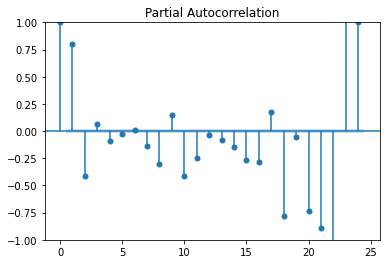

In [ ]:
plot_pacf(hour_seasonal, lags=24)
plt.show()

It's hard to define the value of P from the plot. We'll start with the value P=1.

The Q order can be calculated from the Autocorrelation (ACF) plot.

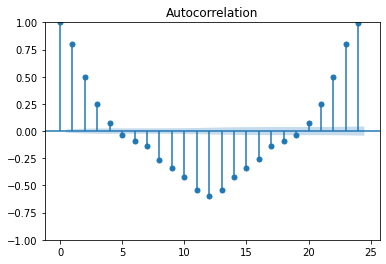

In [ ]:
plot_acf(hour_seasonal, lags=24)
plt.show()

Let Q = 1.

In [ ]:
model=sm.tsa.statespace.SARIMAX(data[:-742].cnt, order=(2, 1, 2),
                                        seasonal_order=(1, 1, [1], 24)).fit(disp=-1)

In [ ]:
mean_absolute_error(test, model.predict(start = 16637, end = 17378))

89.71536809178122

In [ ]:
data_pred = data[-742:].copy()
data_pred['cnt'] = list(model.predict(start = 16637, end = 17378))

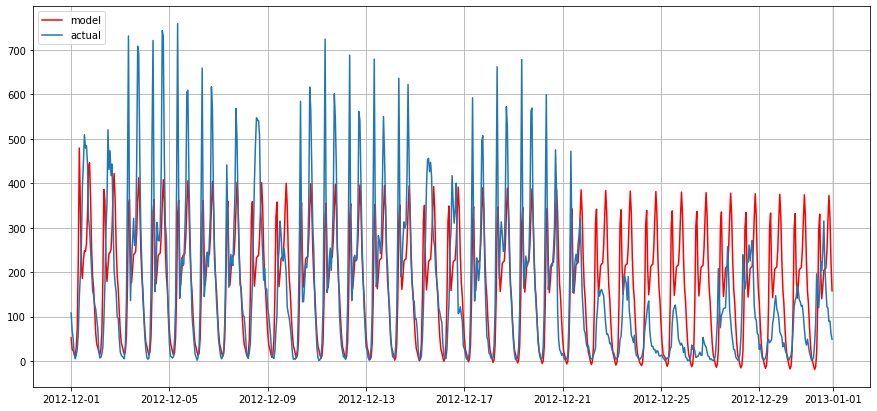

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(data_pred, color='r', label="model")
plt.axvspan(data.index[-1], data_pred.index[-1], alpha=0.5, color='lightgrey')
plt.plot(data.cnt[-742:], label="actual")
plt.legend()
plt.grid(True);

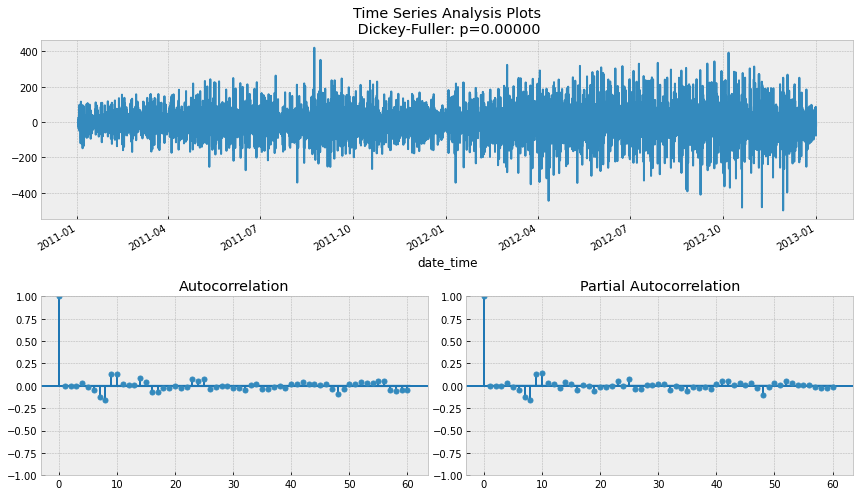

In [ ]:
tsplot(model.resid[24+1:], lags=60)

#Prophet

In [ ]:
data_prophet = pd.DataFrame(
    {
        'ds': data.index,
        'y': data.cnt
    }
)

data_prophet = data_prophet.reset_index().drop(columns=['date_time'])
data_prophet

ds    y
0     2011-01-01 00:00:00   16
1     2011-01-01 01:00:00   40
2     2011-01-01 02:00:00   32
3     2011-01-01 03:00:00   13
4     2011-01-01 04:00:00    1
...                   ...  ...
17374 2012-12-31 19:00:00  119
17375 2012-12-31 20:00:00   89
17376 2012-12-31 21:00:00   90
17377 2012-12-31 22:00:00   61
17378 2012-12-31 23:00:00   49

[17379 rows x 2 columns]

In [ ]:
model = Prophet()
model.fit(data_prophet[:-742])

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
future = pd.DataFrame(columns=['ds'])
future['ds']= pd.to_datetime(data_prophet['ds'][-742:])

preds = model.predict(df=future)

In [ ]:
mean_absolute_error(preds['yhat'], y_test)

108.8608169485125

#Conclusions

Adding lags as new features improves linear regression model results. The best MAE obtained with LinearRegression is ~73.5 (using day-by-day prediction).

To improve linear models, we can apply, for example, window statistics (use Max/min value of series in a window, average/median value in a window or window variance as features). Also, we could use the features engineered in previous HW.

All the models for time-series forecasting gave poor results. The best MAE (89.7) gave SARIMAX. To improve the performance of time series forecasting models, more attention is needed to explore the data specifics. I believe these approaches can give much better results but I couldn't delve deeper into this topic due to lack of time.

Comparing obtained results with ones obtained using Advanced Regression techniques in the previous homework, looking only at the metrics, we can say that the models from the previous HW gave better results. However, in the previous HW, we used a different approach to split the data into train and test subsets so comparing the MAE results only is not enough to make conclusions. Compared to the random selection of the test set in the previous HW, here we can be sure that there is no data leakage.